### Analyze metadata predictions

In [ ]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import typing as t
import pickle
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)  # Set the logging level

# Create a handler
handler = logging.StreamHandler()

# Create and set a formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

# To suppress the stupid AnnData warning ...
warnings.filterwarnings("ignore", category=UserWarning, message="Transforming to str index.")

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext
from cellarium.ml.utilities.inference.metadata_benchmarking.calculate_metrics import \
    calculate_metrics_for_prediction_output

In [ ]:
ROOT_PATH = "/home/mehrtash/data"
METADATA_PREDICTIONS_ROOT_PATH = os.path.join(ROOT_PATH, "data", "metadata_predictions")
PREFIX_LIST = [
    "10M_001_bs1536",
    "19M_001_bs2048",
    "30M_001_bs2560",
    "100M_long_run_last"
]
VAL_ADATA_IDX_RANGE = np.arange(1, 111)
N_HOPS_DICT = {
    'cell_type': 3,
    'development_stage': 3,
    'disease': 3,
    'tissue': 3,
    'sex': 0,
}

def load_predictions_anndata(val_adata_idx: int, prefix_idx: int) -> sc.AnnData:
    path = os.path.join(
        METADATA_PREDICTIONS_ROOT_PATH,
        PREFIX_LIST[prefix_idx],
        f"extract_{VAL_ADATA_IDX_RANGE[val_adata_idx]}_metadata_prediction_scores.h5ad")
    return sc.read_h5ad(path)

In [ ]:
ontology_resource_path = os.path.join(ROOT_PATH, "data", "cellariumgpt_artifacts", "ontology")

logger.info("Loading ontology resources ...")
ontology_benchmarking_resource_path_dict = {
    'cell_type': os.path.join(ontology_resource_path, 'cl_benchmarking_resource.pkl'),
    'development_stage': os.path.join(ontology_resource_path, 'hsapdv_benchmarking_resource.pkl'),
    'disease': os.path.join(ontology_resource_path, 'mondo_benchmarking_resource.pkl'),
    'tissue': os.path.join(ontology_resource_path, 'uberon_benchmarking_resource.pkl'),
    'sex': os.path.join(ontology_resource_path, 'sex_benchmarking_resource.pkl'),
}

ontology_propagation_resource_path_dict = {
    'cell_type': os.path.join(ontology_resource_path, 'cl_propagation_resource.pkl'),
    'development_stage': os.path.join(ontology_resource_path, 'hsapdv_propagation_resource.pkl'),
    'disease': os.path.join(ontology_resource_path, 'mondo_propagation_resource.pkl'),
    'tissue': os.path.join(ontology_resource_path, 'uberon_propagation_resource.pkl'),
    'sex': os.path.join(ontology_resource_path, 'sex_propagation_resource.pkl'),
}

# Define number of hops for each metadata key
n_hops_dict = {
    'cell_type': 3,
    'development_stage': 3,
    'disease': 3,
    'tissue': 3,
    'sex': 0,
}

# Load the benchmarking ontology resources
ontology_benchmarking_resource_dicts = {}
for meta_key, path in ontology_benchmarking_resource_path_dict.items():
    with open(path, "rb") as f:
        ontology_benchmarking_resource_dicts[meta_key] = pickle.load(f)

# Load the propagation ontology resources into a separate dictionary
ontology_propagation_resource_dicts = {}
for meta_key, path in ontology_propagation_resource_path_dict.items():
    with open(path, "rb") as f:
        ontology_propagation_resource_dicts[meta_key] = pickle.load(f)

In [ ]:
def convert_meta_adata_to_query_obj_for_scoring(
        meta_adata: sc.AnnData,
        metadata_key: str,
        scores_col_name_suffix: str = "class_probs",
        ontology_term_ids_uns_key_name_suffix: str = "ontology_term_ids",
        ontology_term_id_obs_col_name_suffix: str = "ontology_term_id",
    ) -> t.Tuple[t.List[dict], t.List[str]]:
    scores_col_name = f"{metadata_key}_{scores_col_name_suffix}"
    ontology_term_ids_uns_key_name = f"{metadata_key}_{ontology_term_ids_uns_key_name_suffix}"
    ontology_term_id_obs_col_name = f"{metadata_key}_{ontology_term_id_obs_col_name_suffix}"
    assert scores_col_name in meta_adata.obsm
    assert ontology_term_ids_uns_key_name in meta_adata.uns
    assert ontology_term_id_obs_col_name in meta_adata.obs.columns
    query_objs = []
    ground_truth_ontology_term_ids = []
    obs_index = meta_adata.obs.index.values
    for i_cell in range(len(meta_adata)):
        obs_row = meta_adata.obs.iloc[i_cell]
        ground_truth_ontology_term_id = obs_row[ontology_term_id_obs_col_name]
        query_obj = dict()
        query_obj["query_cell_id"] = obs_index[i_cell]
        query_obj["matches"] = []
        for ontology_term_id, score in zip(
                meta_adata.uns[ontology_term_ids_uns_key_name],
                meta_adata.obsm[scores_col_name][i_cell, :]):
            query_obj["matches"].append({
                "ontology_term_id": ontology_term_id,
                "score": score,
            })
        query_objs.append(query_obj)
        ground_truth_ontology_term_ids.append(ground_truth_ontology_term_id)
    return query_objs, ground_truth_ontology_term_ids

In [76]:
from collections import defaultdict
from tqdm.auto import tqdm

results = defaultdict(list)
eps = 1e-8

for prefix_idx in tqdm(range(len(PREFIX_LIST))):
    prefix = PREFIX_LIST[prefix_idx]
    
    for val_adata_idx in tqdm(range(len(VAL_ADATA_IDX_RANGE))):
        val_adata_id = VAL_ADATA_IDX_RANGE[val_adata_idx]
        meta_adata = load_predictions_anndata(val_adata_idx, prefix_idx)

        results["prefix"].append(prefix)
        results["val_adata_id"].append(val_adata_id)

        for key in ["cell_type", "disease", "development_stage", "tissue", "sex"]:

            # Calculate accuracy
            query_objs, ground_truth_ontology_term_ids = convert_meta_adata_to_query_obj_for_scoring(
                meta_adata=meta_adata,
                metadata_key=key)
            results_df = calculate_metrics_for_prediction_output(
                ground_truth_ontology_term_ids=ground_truth_ontology_term_ids,
                model_predictions=query_objs,
                ontology_resource=ontology_benchmarking_resource_dicts[key],
                num_hops=n_hops_dict[key],
                metric_style="hop_k_call").dropna()
            
            for n_hops in range(N_HOPS_DICT[key] + 1):
                hop_accuracy = results_df[f"hop_{n_hops}_call"].mean()
                results[f"{key}_hop_{n_hops}_accuracy"].append(hop_accuracy)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [111]:
df = pd.DataFrame(results)

### Coarse tissue for each validation dataset

In [118]:
validation_meta_df = pd.read_csv(
    os.path.join(ROOT_PATH, "data", "cellariumgpt_artifacts", "cellxgene_validation_donors__third_draft.csv"))

# Stephen's validatdion table
# what we have called intestine is actually "small intestine"
tissue_ontology_term_id_to_coarse_name_map = dict()
for row in validation_meta_df['tissue_name_ont_coarsename_coarseont'].values:
    split_row = row.strip("()").split(', ')
    coarse_name = split_row[2].strip("'")
    if coarse_name == "intestine":
        coarse_name = "small intestine"
    tissue_ontology_term_id_to_coarse_name_map[split_row[1].strip("'")] = coarse_name

from tqdm.notebook import tqdm

val_adata_id_to_coarse_tissue_map = dict()
for val_idx in tqdm(range(1, 111)):
    
    val_adata_path = os.path.join(ROOT_PATH, "data", "cellariumgpt_validation", f"extract_{val_idx}.h5ad")
    val_adata = sc.read_h5ad(val_adata_path)

    obs_df = val_adata.obs
    val_adata_id_to_coarse_tissue_map[val_idx] = obs_df['tissue_ontology_term_id'].map(
        tissue_ontology_term_id_to_coarse_name_map).iloc[0]

  0%|          | 0/110 [00:00<?, ?it/s]

In [123]:
df['coarse_tissue'] = df['val_adata_id'].map(val_adata_id_to_coarse_tissue_map)

### Plotting

In [125]:
master_df = df.copy()

In [129]:
master_df['coarse_tissue'].value_counts()

coarse_tissue
blood              136
brain              112
lung                60
heart               36
small intestine     32
liver               24
kidney              20
thymus               8
nose                 8
eye                  4
Name: count, dtype: int64

In [145]:
df = master_df.copy()

In [ ]:
master_df.to_csv(
    os.path.join(ROOT_PATH, "data", "cellariumgpt_artifacts", "metadata_prediction_scores.csv"), index=False)

In [146]:
df

,prefix,val_adata_id,cell_type_hop_0_accuracy,cell_type_hop_1_accuracy,cell_type_hop_2_accuracy,cell_type_hop_3_accuracy,disease_hop_0_accuracy,disease_hop_1_accuracy,disease_hop_2_accuracy,disease_hop_3_accuracy,development_stage_hop_0_accuracy,development_stage_hop_1_accuracy,development_stage_hop_2_accuracy,development_stage_hop_3_accuracy,tissue_hop_0_accuracy,tissue_hop_1_accuracy,tissue_hop_2_accuracy,tissue_hop_3_accuracy,sex_hop_0_accuracy,coarse_tissue
0,10M_001_bs1536,1,0.626214,0.632147,0.647789,0.906688,0.8950,0.8950,0.8950,0.8950,0.0000,1.0,1.0,1.0,0.0000,0.000000,0.0795,0.0795,0.951000,brain
1,10M_001_bs1536,2,0.554500,0.844500,0.985000,1.000000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,1.0,1.0,0.0000,0.000000,1.0000,1.0000,0.131500,blood
2,10M_001_bs1536,3,0.716000,0.847000,0.968000,1.000000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,1.0,1.0,0.0040,0.004000,1.0000,1.0000,0.249500,blood
3,10M_001_bs1536,4,0.579492,0.863283,0.895391,0.924909,0.0000,0.0000,0.0000,1.0000,0.0000,1.0,1.0,1.0,0.0000,0.000000,1.0000,1.0000,0.893500,small intestine
4,10M_001_bs1536,5,0.635500,0.859000,0.970000,1.000000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,1.0,1.0,0.0045,0.004500,1.0000,1.0000,0.148000,blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,100M_long_run_last,106,0.665000,0.700000,0.782000,0.815500,0.0000,0.0000,0.0000,0.0000,0.0035,1.0,1.0,1.0,0.0000,0.901000,1.0000,1.0000,0.724500,lung
436,100M_long_run_last,107,0.580040,0.743083,0.821146,0.928854,0.9070,0.9070,0.9070,0.9070,0.0000,1.0,1.0,1.0,0.1275,0.127500,1.0000,1.0000,0.925500,lung
437,100M_long_run_last,108,0.408931,0.678026,0.922444,0.982374,0.9815,0.9815,0.9815,0.9815,0.0000,1.0,1.0,1.0,0.0230,0.023000,1.0000,1.0000,0.537000,lung
438,100M_long_run_last,109,0.397308,0.531890,0.581042,0.599766,1.0000,1.0000,1.0000,1.0000,0.0000,1.0,1.0,1.0,0.0000,0.939146,1.0000,1.0000,0.857226,brain


/var/tmp/ipykernel_119159/3100616606.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Greens')((i + 1) / (n + 1))
/var/tmp/ipykernel_119159/3100616606.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Reds')((i + 1) / (n + 1))
/var/tmp/ipykernel_119159/3100616606.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Blues')((i + 1) / (n + 1))
/var/tmp/ipykernel_119159/3100616606.py:57: Matplotl

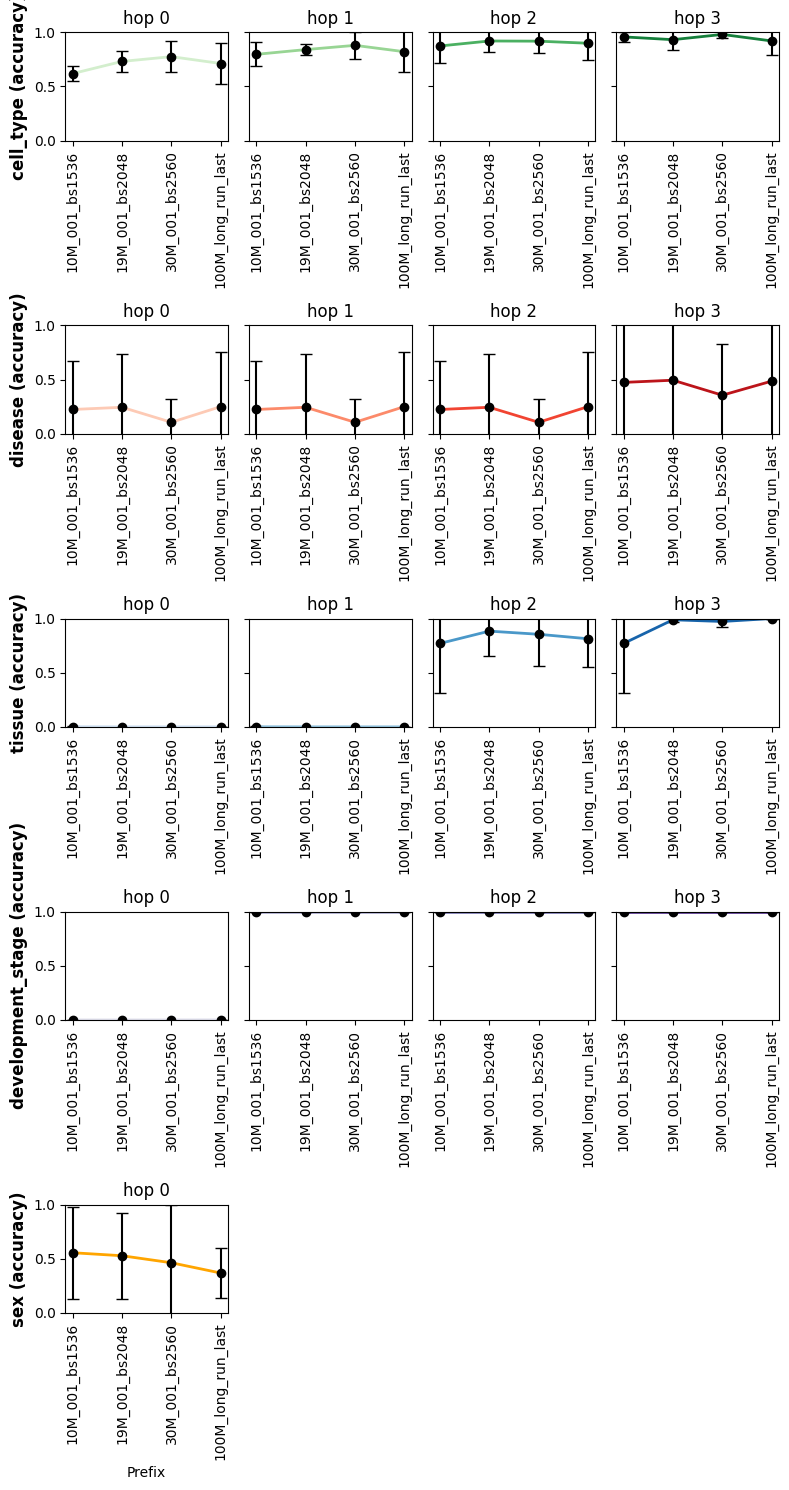

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# -------------------------------
# User-specified options:
# Choose which metric to plot: 'f1', 'sensitivity', or 'specificity'
value_to_plot = 'accuracy'  
# Flag to select summary statistic: True uses mean/std, False uses median/IQR.
use_mean = True
# df = master_df[master_df['coarse_tissue'] == 'blood'].copy()
# df = master_df.copy()
# -------------------------------

# Define metric groups and available hops.
# For 'sex', only hop 0 is available.
metric_groups = {
    'cell_type': [0, 1, 2, 3],
    'disease': [0, 1, 2, 3],
    'tissue': [0, 1, 2, 3],
    'development_stage': [0, 1, 2, 3],
    'sex': [0]
}

# Build the list of metric columns (e.g., "cell_type_hop_0_f1")
selected_metrics = []
for group, hops in metric_groups.items():
    for hop in hops:
        selected_metrics.append(f"{group}_hop_{hop}_{value_to_plot}")

# Precompute a color palette for each metric column.
palette = {}

# For cell_type: use Greens.
cell_metrics = [f"cell_type_hop_{hop}_{value_to_plot}" for hop in metric_groups['cell_type']]
n = len(cell_metrics)
for i, m in enumerate(cell_metrics):
    palette[m] = cm.get_cmap('Greens')((i + 1) / (n + 1))

# For disease: use Reds.
disease_metrics = [f"disease_hop_{hop}_{value_to_plot}" for hop in metric_groups['disease']]
n = len(disease_metrics)
for i, m in enumerate(disease_metrics):
    palette[m] = cm.get_cmap('Reds')((i + 1) / (n + 1))

# For tissue: use Blues.
tissue_metrics = [f"tissue_hop_{hop}_{value_to_plot}" for hop in metric_groups['tissue']]
n = len(tissue_metrics)
for i, m in enumerate(tissue_metrics):
    palette[m] = cm.get_cmap('Blues')((i + 1) / (n + 1))

# For development_stage: use Purples.
dev_metrics = [f"development_stage_hop_{hop}_{value_to_plot}" for hop in metric_groups['development_stage']]
n = len(dev_metrics)
for i, m in enumerate(dev_metrics):
    palette[m] = cm.get_cmap('Purples')((i + 1) / (n + 1))

# For sex: assign a fixed color (e.g., orange).
sex_metrics = [f"sex_hop_{hop}_{value_to_plot}" for hop in metric_groups['sex']]
for m in sex_metrics:
    palette[m] = 'orange'

# Melt the dataframe into long format for the selected metrics.
# Assume your original dataframe is named `df`.
df_long = df.melt(
    id_vars=['prefix', 'val_adata_id'],
    value_vars=selected_metrics,
    var_name='metric',
    value_name=value_to_plot
)
# Drop any rows with NaN values for the chosen metric.
df_long = df_long.dropna(subset=[value_to_plot])

# Determine grid size: one row per metric group, columns = max hops among groups.
n_rows = len(metric_groups)
max_cols = max(len(hops) for hops in metric_groups.values())

fig, axes = plt.subplots(n_rows, max_cols, figsize=(2 * max_cols, 3 * n_rows), sharey=True)

# Loop over each metric group (row) and each hop (column).
for row_idx, (group, hops) in enumerate(metric_groups.items()):
    for col_idx in range(max_cols):
        # Turn off extra panels.
        if col_idx >= len(hops):
            axes[row_idx, col_idx].axis('off')
            continue

        hop = hops[col_idx]
        metric_name = f"{group}_hop_{hop}_{value_to_plot}"
        ax = axes[row_idx, col_idx]

        # Filter data for the current metric and drop any NaNs.
        df_metric = df_long[df_long['metric'] == metric_name].dropna(subset=[value_to_plot])

        # Compute summary statistics per prefix.
        if use_mean:
            stats = df_metric.groupby('prefix')[value_to_plot].agg(['mean', 'std']).reindex(PREFIX_LIST)
            y_vals = stats['mean']
            y_err = stats['std']
        else:
            stats = df_metric.groupby('prefix').agg(
                median=(value_to_plot, np.median),
                q1=(value_to_plot, lambda x: x.quantile(0.25)),
                q3=(value_to_plot, lambda x: x.quantile(0.75))
            ).reindex(PREFIX_LIST)
            y_vals = stats['median']
            y_err_lower = y_vals - stats['q1']
            y_err_upper = stats['q3'] - y_vals
            y_err = [y_err_lower.values, y_err_upper.values]

        x = np.arange(len(PREFIX_LIST))
        # Retrieve the precomputed color (default to gray if not found).
        line_color = palette.get(metric_name, 'gray')

        # Plot black markers with error bars.
        ax.errorbar(
            x, y_vals, yerr=y_err,
            fmt='o', color='black', ecolor='black',
            capsize=4, markersize=6, linestyle='None'
        )
        # Connect the markers with a line in the precomputed color.
        ax.plot(x, y_vals, color=line_color, linestyle='-', linewidth=2)

        ax.set_xticks(x)
        ax.set_xticklabels(PREFIX_LIST, rotation=90)
        ax.set_ylim(0, 1)
        # Set the title to show the hop value.
        ax.set_title(f"hop {hop}")

        # Label the y-axis with the metric group on the leftmost panel.
        if col_idx == 0:
            ax.set_ylabel(f"{group} ({value_to_plot})", fontsize=12, fontweight='bold')
        # Label the x-axis on the bottom row.
        if row_idx == n_rows - 1:
            ax.set_xlabel('Prefix')

plt.tight_layout()
plt.show()


### Playground

In [ ]:
best_indices = np.argmax(meta_adata.obsm['cell_type_class_probs'], -1)
best_probs = np.max(meta_adata.obsm['cell_type_class_probs'], -1)
best_names = meta_adata.uns['cell_type_ontology_term_ids'][best_indices]
best_labels = list(map(ontology_propagation_resource_dicts[metadata_key]['ontology_term_id_to_label'].get, best_names))
term_id_to_idx_map = {term_id: idx for idx, term_id in enumerate(meta_adata.uns[f'{metadata_key}_ontology_term_ids'])}
gt_indices = list(map(term_id_to_idx_map.get, meta_adata.obs[f'{metadata_key}_ontology_term_id'].values))
bad_indices = [i for i, idx in enumerate(gt_indices) if idx is None]
for i in bad_indices:
    gt_indices[i] = 0
gt_probs = meta_adata.obsm[f'{metadata_key}_class_probs'][np.arange(len(gt_indices)), gt_indices]
gt_probs[bad_indices] = np.nan

In [ ]:
new_obs = meta_adata.obs.copy()
new_obs['best_label'] = best_labels
new_obs['best_prob'] = best_probs
new_obs['gt_prob'] = gt_probs
new_obs['hop_2_inclusion_score'] = results_df["hop_2_inclusion_score"].values
new_obs = new_obs[[metadata_key, 'best_label', 'best_prob', 'gt_prob', 'hop_2_inclusion_score', 'cell_type_hop_2_sensitivity']]


In [ ]:
np.mean(probs)

In [ ]:
new_obs['cell_type_hop_2_sensitivity'].mean()

In [ ]:
# show all rows in a context manager
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(new_obs)

In [ ]:
for query_obj in query_objs:
    if query_obj["query_cell_id"] == "26540767":
        break
term_id_to_score_map = {match["ontology_term_id"]: match["score"] for match in query_obj["matches"]}

In [ ]:
cell_type_label = 'oligodendrocyte precursor cell'
cell_type_label_to_term_id = {
    label: term_id
    for term_id, label in ontology_propagation_resource_dicts[metadata_key]['ontology_term_id_to_label'].items()}
cell_type_term_id = cell_type_label_to_term_id[cell_type_label]

In [ ]:
from cellarium.ml.utilities.inference.metadata_benchmarking.calculate_metrics import \
    calculate_hop_inclusion_scores

calculate_hop_inclusion_scores(query_obj, cell_type_term_id, 3, ontology_benchmarking_resource_dicts[metadata_key])

In [ ]:
for i_hop in range(4):

    nodes = ontology_benchmarking_resource_dicts[metadata_key][cell_type_term_id][f'hop_{i_hop}']['nodes']
    ancestors = ontology_benchmarking_resource_dicts[metadata_key][cell_type_term_id][f'hop_{i_hop}']['all_ancestors']
    descendants = ontology_benchmarking_resource_dicts[metadata_key][cell_type_term_id][f'hop_{i_hop}']['all_descendants']


    print(f"All nodes (hop {i_hop}):")
    total_score = 0
    for node in nodes:
        label = ontology_propagation_resource_dicts[metadata_key]['ontology_term_id_to_label'][node]
        score = term_id_to_score_map[node] if node in term_id_to_score_map else 0
        total_score += score
        print(f" - {label} ({score:.3f})")
    print(f"Total score: {total_score:.3f}")
    print('')

    
    print(f"All ancestors (hop {i_hop}):")
    total_score = 0
    for ancestor in ancestors:
        label = ontology_propagation_resource_dicts[metadata_key]['ontology_term_id_to_label'][ancestor]
        score = term_id_to_score_map[ancestor] if ancestor in term_id_to_score_map else 0
        total_score += score
        print(f" - {label} ({score:.3f})")
    print(f"Total score: {total_score:.3f}")
    print('')

    print(f"All descendants (hop {i_hop}):")
    total_score = 0
    for descendant in descendants:
        label = ontology_propagation_resource_dicts[metadata_key]['ontology_term_id_to_label'][descendant]
        score = term_id_to_score_map[descendant] if descendant in term_id_to_score_map else 0
        total_score += score
        print(f" - {label} ({score:.3f})")
    print(f"Total score: {total_score:.3f}")
    print('')
    
    print('-----------------------\n')